In [1]:
import networkx as nx
import os
import json
import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm import tqdm
import gc

### 1.Load Topology

In [2]:
def loadTopo(file):    
    with open(file) as f:
        net_json = json.load(f)

    net_graph = nx.Graph()
    for node in net_json['nodes']:
        net_graph.add_node(node['id'], label=node['label'])

    for edge in net_json['edges']:
        net_graph.add_edge(edge['src'], edge['dst'], weight=edge['weight'])
        net_graph.add_edge(edge['dst'], edge['src'], weight=edge['weight'])
    print(file,":",net_graph.number_of_nodes(),"nodes, ",net_graph.number_of_edges(),"edges,")
    return net_graph

In [3]:
topo = []
path = "data"
list_of_topo = [os.path.join(path, file)for file in ['ATT.json','B4.json','Bellcanada.graph.json','IBM.json','spineLeaf.json','UsSignal.graph.json','VtlWavenet2011.graph.json']]
files = os.listdir(path)
for file in files:
    if not file.endswith('.json'):
        continue
    file_path = os.path.join(path, file)
    if file_path in list_of_topo:
        topo.append(loadTopo(file_path))

data\ATT.json : 25 nodes,  56 edges,
data\B4.json : 12 nodes,  19 edges,
data\Bellcanada.graph.json : 48 nodes,  64 edges,
data\IBM.json : 17 nodes,  23 edges,
data\spineLeaf.json : 10 nodes,  16 edges,
data\UsSignal.graph.json : 61 nodes,  78 edges,
data\VtlWavenet2011.graph.json : 92 nodes,  96 edges,


## 2.Algorithm

In [4]:
def fullmesh(topo, slices):
    res = 0
    for slice in slices:
        res += slice.number_of_nodes() * (slice.number_of_nodes() - 1) / 2
    return res

In [5]:
def init(topo):
    region = list(topo.nodes())
    represent = set()
    node = list(topo.nodes())
    be = node[0]
    degree = dict(topo.degree())
    # 按度排序遍历node
    node.sort(key=lambda x:degree[x], reverse=True)
    for i in node:
        if region[i-be] == i:
            for j in topo.neighbors(i):
                if region[j-be] == j:
                    region[j-be] = i
            represent.add(i)
    return region, represent

def region_size(region,represent):
    size = 0
    for node in region:
        if node == represent:
            size += 1
    return size

def region_num(region):
    return len(set(region))

def unit(topo,region,represent):
    
    pair = []
    for node in represent:
        for neighbor in topo.neighbors(node):
            if neighbor in represent and neighbor != node:
                if (neighbor,node) not in pair:
                    pair.append((node,neighbor))
    if pair == []:
        return False,region,represent
    min_pair = pair[0]
    min_size = region_size(region,min_pair[0]) * region_size(region,min_pair[1])
    for p in pair:
        size = region_size(region,p[0]) * region_size(region,p[1])
        if size < min_size:
            min_size = size
            min_pair = p
    if(region_num(region) * 3 - min_size*2 -2) > 0:
        # 合并
        for i in range(len(region)):
            if region[i] == min_pair[1]:
                region[i] = min_pair[0]
        represent.remove(min_pair[1])
        for r in region:
            if r not in represent:
                print("error")
                print("re",region)
                print("del",min_pair[0],min_pair[1])
                print("pre",represent)
                print(pair)
        return True,region,represent
    return False,region,represent

In [6]:
def partition(topo):
    region, represent = init(topo)
    while True:
        flag, region, represent = unit(topo,region,represent)
        if not flag:
            break
    return region,represent

In [7]:
def randomcolor():
    colorArr = ['1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
    color ="#"+''.join([random.choice(colorArr) for i in range(6)])
    return color

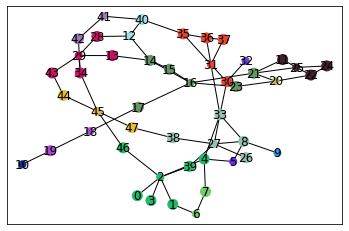

In [8]:
topology = topo[2]

region,represent = partition(topology)
#represent和随机颜色的字典
colormap = {}
for node in represent:
    colormap[node] = randomcolor()

color = []
for node in region:
    color.append(colormap[node])

node_size = []
be = list(topology.nodes())[0]
for i in range(topology.number_of_nodes()):
    if i+be in represent:
        node_size.append(50)
    else:
        node_size.append(100)

pos = nx.spring_layout(topology)
nx.draw_networkx(topology, pos, node_color=color, with_labels=True, node_size=node_size)
plt.show()

## 3.Slice

In [9]:
# 随机创建切片
def createSlice(topo, slice_num, slice_size):
    slices = []
    nodes = list(topo.nodes())
    #进度条
    for i in tqdm(range(slice_num)):
        slice = nx.Graph()
        for j in range(slice_size):
            temp = np.random.randint(0, topo.number_of_nodes())
            node = nodes[temp]
            slice.add_node(node)
        for node in slice.nodes():
            for neighbor in topo.neighbors(node):
                if neighbor in slice.nodes():
                    slice.add_edge(node, neighbor)
        # slice node id 从0开始
        slice = nx.convert_node_labels_to_integers(slice)
        # 随机再添加一些边保证联通
        for i in range(slice_size):
            temp1 = np.random.randint(0, slice.number_of_nodes())
            temp2 = np.random.randint(0, slice.number_of_nodes())
            if temp1 != temp2 and not slice.has_edge(list(slice.nodes())[temp1], list(slice.nodes())[temp2]):
                slice.add_edge(list(slice.nodes())[temp1], list(slice.nodes())[temp2])
        while((nx.is_k_edge_connected(slice,1)) != 1):
            # 连通分量
            components = list(nx.connected_components(slice))
            # 随机选择两个连通分量中的节点
            temp1 = np.random.randint(0, len(components))
            temp2 = np.random.randint(0, len(components))
            node1 = list(components[temp1])[np.random.randint(0, len(components[temp1]))]
            node2 = list(components[temp2])[np.random.randint(0, len(components[temp2]))]
            slice.add_edge(node1, node2)
        slices.append(slice)
        #print("slice",i,":",slice.number_of_nodes(),"nodes, ",slice.number_of_edges(),"edges,",nx.is_k_edge_connected(slice,1),"connected")
    return slices

## 4.Other Desgin

In [10]:
def partition_num(slices):
    res = 0
    for slice in slices:
        region, represent = partition(slice)
        intra_region = {}
        for p in represent:
            intra_region[p] = 0
        for r in region:
            intra_region[r] += 1
        for i in intra_region:
            res += intra_region[i] * (intra_region[i] - 1) / 2
        res += len(represent) * (len(represent) - 1) / 2
    return res

In [11]:
def pruned_partition_num(slices):
    res={1:0}
    for slice in slices:
        #print(nx.is_k_edge_connected(slice,1))
        #print(slice.edges())
        region, represent = partition(slice)
        #所有represent间的路径
        path = []
        for i in represent:
            for j in represent:
                if i < j:
                    path.append(nx.shortest_path(slice, source=i, target=j))
        #相同region内节点对间的路径
        for p in represent:
            node = []
            for i, r in enumerate(region):
                if r == p:
                    node.append(i)
            for i in node:
                for j in node:
                    if i < j :
                        path.append(nx.shortest_path(slice, source=i, target=j))
        #按照路径长度排序
        path.sort(key=lambda x:len(x))
        
        #计算真包含的路径
        father = [i for i in range(len(path))]
        def find(x):
            if father[x] != x:
                father[x] = find(father[x])
            return father[x]
            
        for i in range(len(path)):
            flag = True
            for j in range(i+1, len(path)):
                if set(path[i]).issubset(set(path[j])):
                    flag = True
                    if len(path[father[i]]) < len(path[father[j]]):    
                        father[i] = find(father[j])
                        
        for i in range(len(path)):
            if father[i] == i:
                res[1] += 1
            else:
                n = 1
                while father[i] != i and n < 20:
                    i = father[i]
                    n += 1
                if n in res:
                    res[n] += 1
                else:
                    res[n] = 1
    return res

In [12]:
def avg_pruned_partition_num(res):
    ans = 0
    for key in res:
        ans += res[key] * key
    sum = 0
    for key in res:
        sum += len(res)
    ans = ans / sum
    return ans

In [13]:
def fail_prunned(fail,epoch,slices):
    res={1:0}
    for e in tqdm(range(epoch)):
        sign = False
        for slice in slices:
            if random.random() < fail:
                sign = True
            #print(nx.is_k_edge_connected(slice,1))
            #print(slice.edges())
            region, represent = partition(slice)
            #所有represent间的路径
            path = []
            for i in represent:
                for j in represent:
                    if i < j:
                        path.append(nx.shortest_path(slice, source=i, target=j))
            #相同region内节点对间的路径
            for p in represent:
                node = []
                for i, r in enumerate(region):
                    if r == p:
                        node.append(i)
                for i in node:
                    for j in node:
                        if i < j :
                            path.append(nx.shortest_path(slice, source=i, target=j))
            #按照路径长度排序
            path.sort(key=lambda x:len(x))
            
            #计算真包含的路径
            father = [i for i in range(len(path))]
            def find(x):
                if father[x] != x:
                    father[x] = find(father[x])
                return father[x]
                
            for i in range(len(path)):
                flag = True
                for j in range(i+1, len(path)):
                    if set(path[i]).issubset(set(path[j])):
                        flag = True
                        if len(path[father[i]]) < len(path[father[j]]):    
                            father[i] = find(father[j])
                            
            for i in range(len(path)):
                if father[i] == i:
                    res[1] += 1
                elif sign == False:
                    n = 1
                    while father[i] != i and n < 20:
                        i = father[i]
                        n += 1
                    if n in res:
                        res[n] += 1
                    else:
                        res[n] = 1
    for key in res:
        res[key] = res[key] / epoch
    return res
        

### 5.Evaluation

In [14]:
def main(topo,slice_num,slice_size):
    data = []
    for topology in topo:
        res = [0,0,0,0]
        slice_size = int(topology.number_of_nodes() * slice_size)
        print("topology:",topology.number_of_nodes(),"nodes,",topology.number_of_edges(),"edges")
        slices = createSlice(topology, slice_num, slice_size)
        res[0] = fullmesh(topology, slices)
        print("fullmesh:",res[0])
        res[1] = partition_num(slices)
        print("After step 1:",res[1])
        res[2] = avg_pruned_partition_num(pruned_partition_num(slices))
        print("After step 2:",res[2])
        res[3] = avg_pruned_partition_num(fail_prunned(0.03,10,slices))
        print("After step 3:",res[3])
        data.append(res)
        del slices
        del res
        gc.collect()
    return data

### 6.Plot

In [16]:
plt.style.use(['science','ieee'])
plt.rcParams['legend.frameon'] = True

In [17]:
#IEEE 配色
#colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
colors = ['#cc3300', '#1d8fff', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

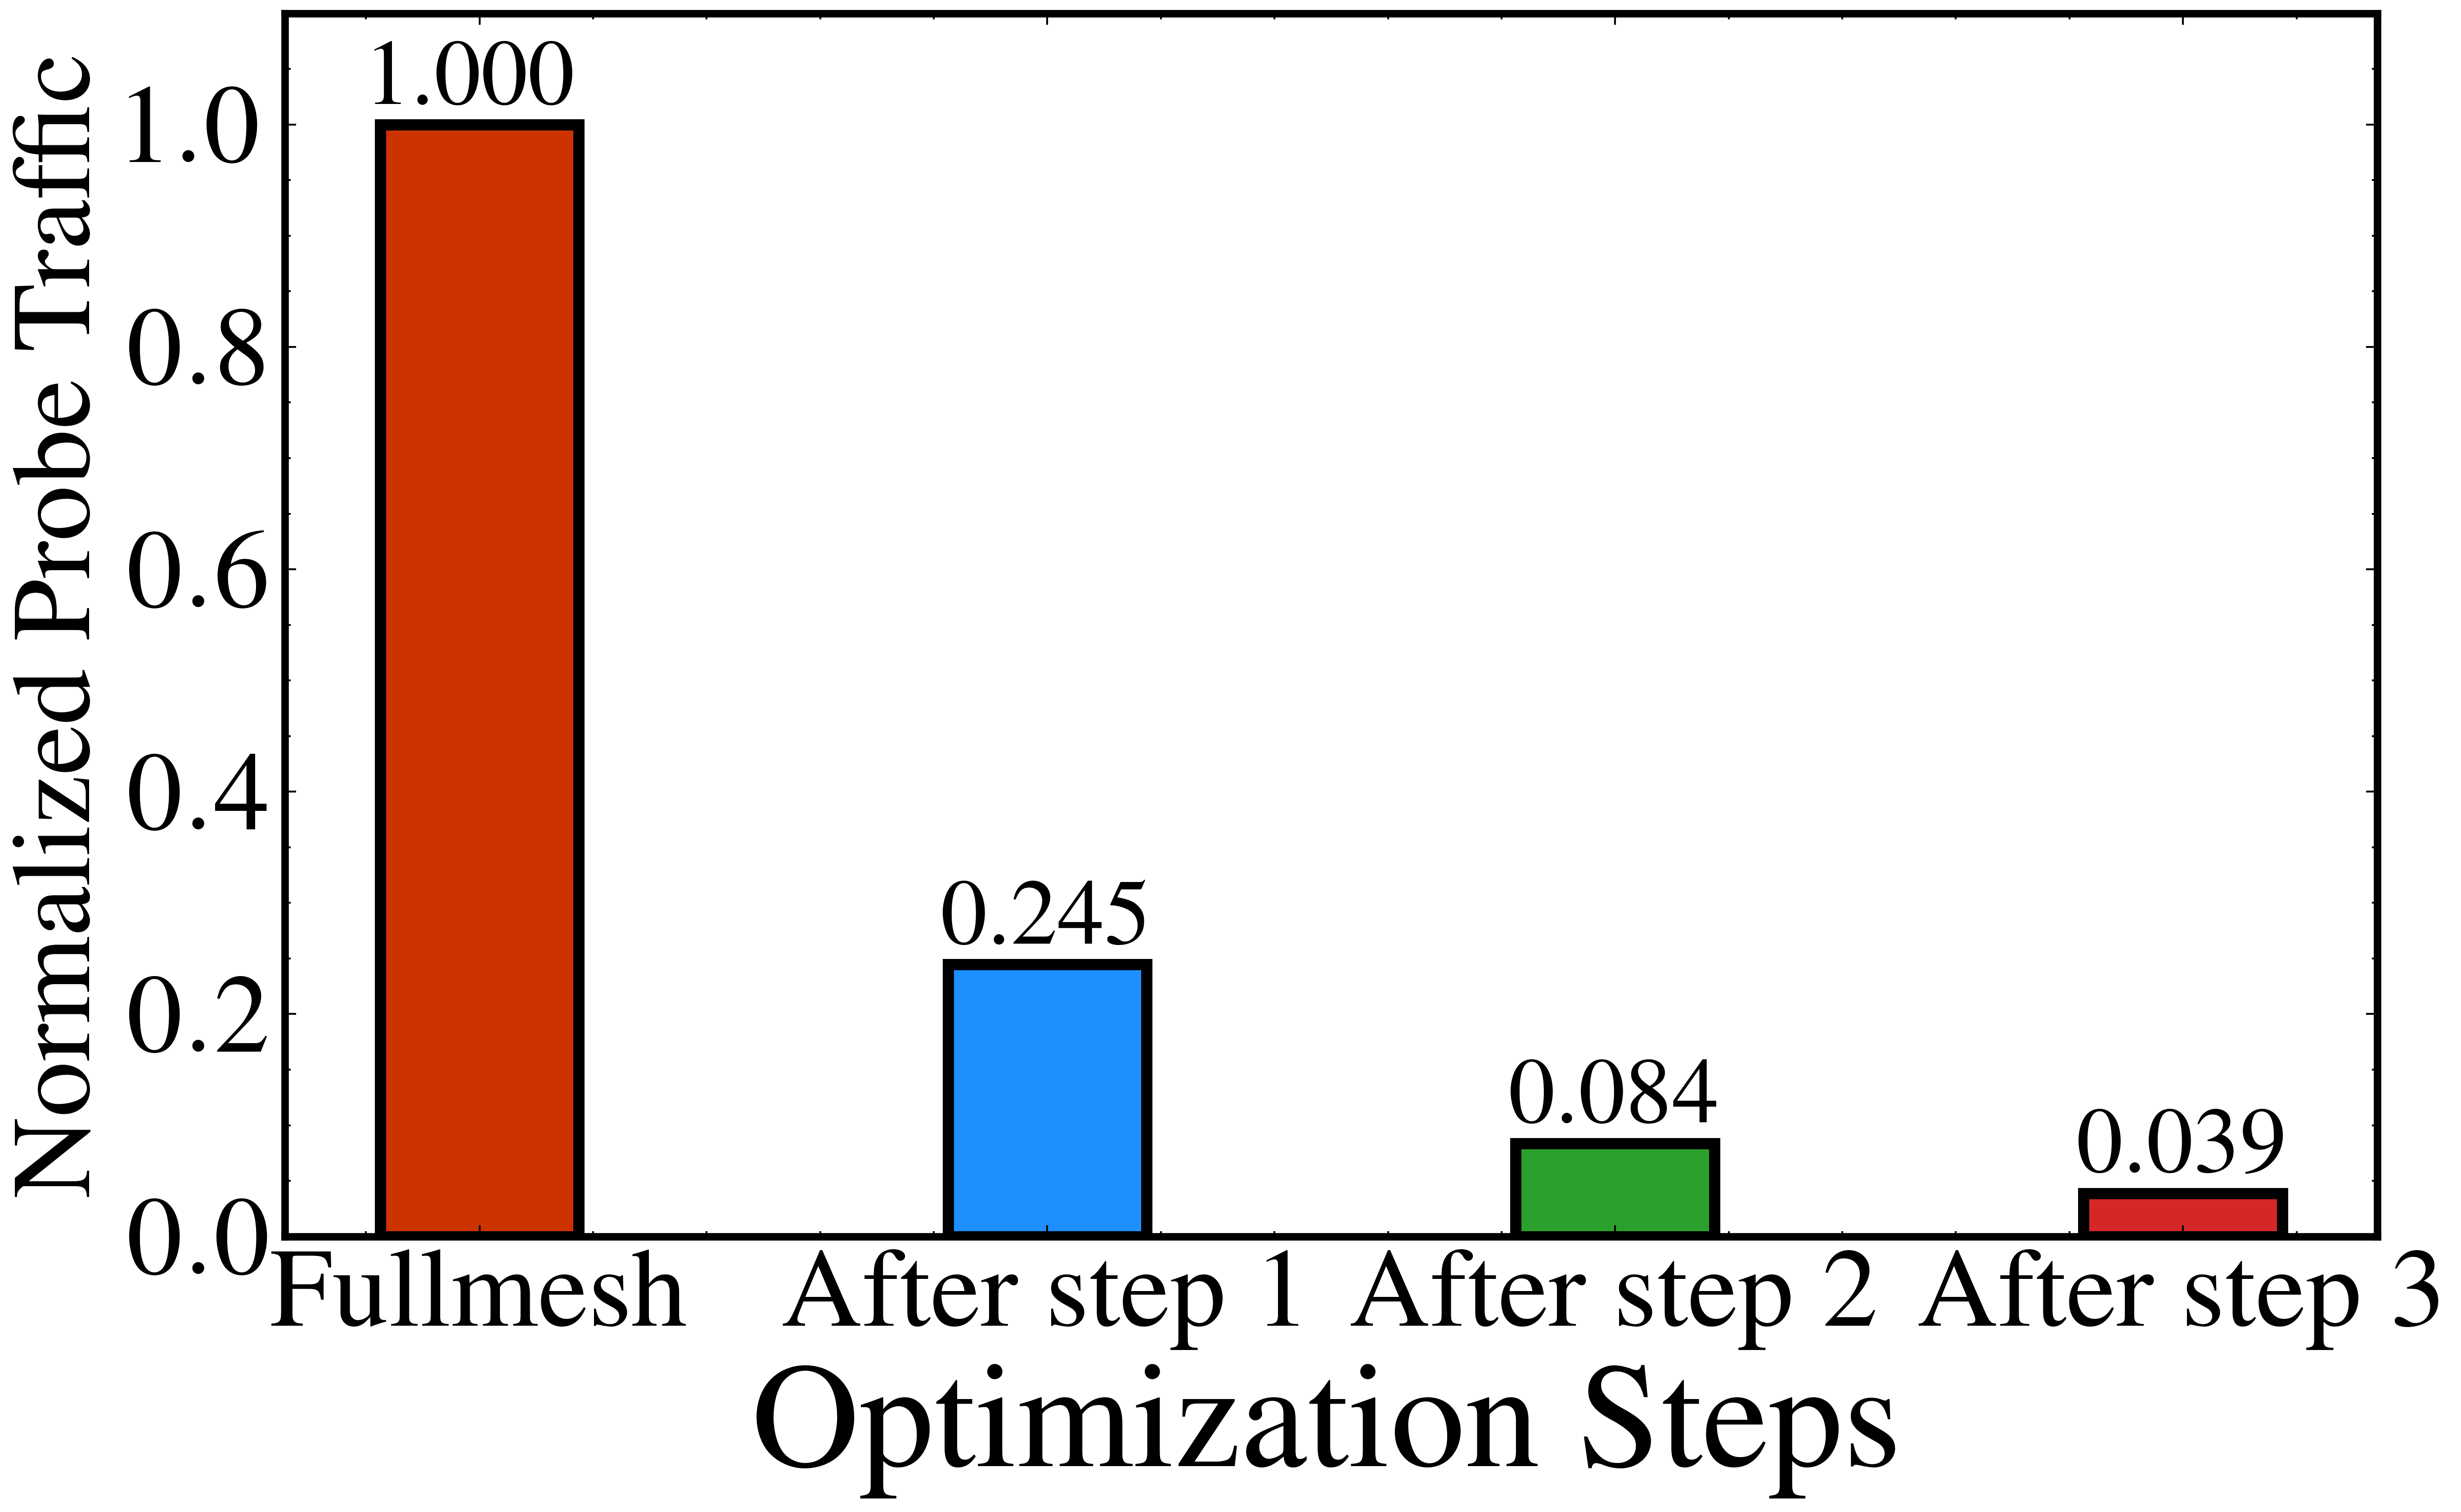

In [18]:
res = []
for i in range(4):
    sum = 0
    for j in range(7):
        sum += data[j][i]
    res.append(sum/7)
res = [i / res[0] for i in res]
#colors = ['#FF6347', '#4682B4', '#006400', '#8B008B']
#柱状图
fig, ax = plt.subplots(figsize=(10, 6))
#ax.set_facecolor((249/255,247/255,243/255))
x = np.arange(4)
bar_width = 0.35
bars=plt.bar(x, res, bar_width, color=colors,linewidth=3, edgecolor='black')
plt.ylim(0,1.1)
#上面写上数字,小数点两位
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom',fontsize=25)
ax = plt.gca() # 获取当前坐标轴
ax.spines['bottom'].set_linewidth(2) 
ax.spines['left'].set_linewidth(2) 
ax.spines['right'].set_linewidth(2) 
ax.spines['top'].set_linewidth(2)
plt.xticks(x, ['Fullmesh', 'After step 1', 'After step 2', 'After step 3'], fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('Optimization Steps', fontsize=40)
plt.ylabel('Normalized Probe Traffic', fontsize=30)
plt.savefig('plot//d3ea.png', dpi=600, bbox_inches='tight')


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


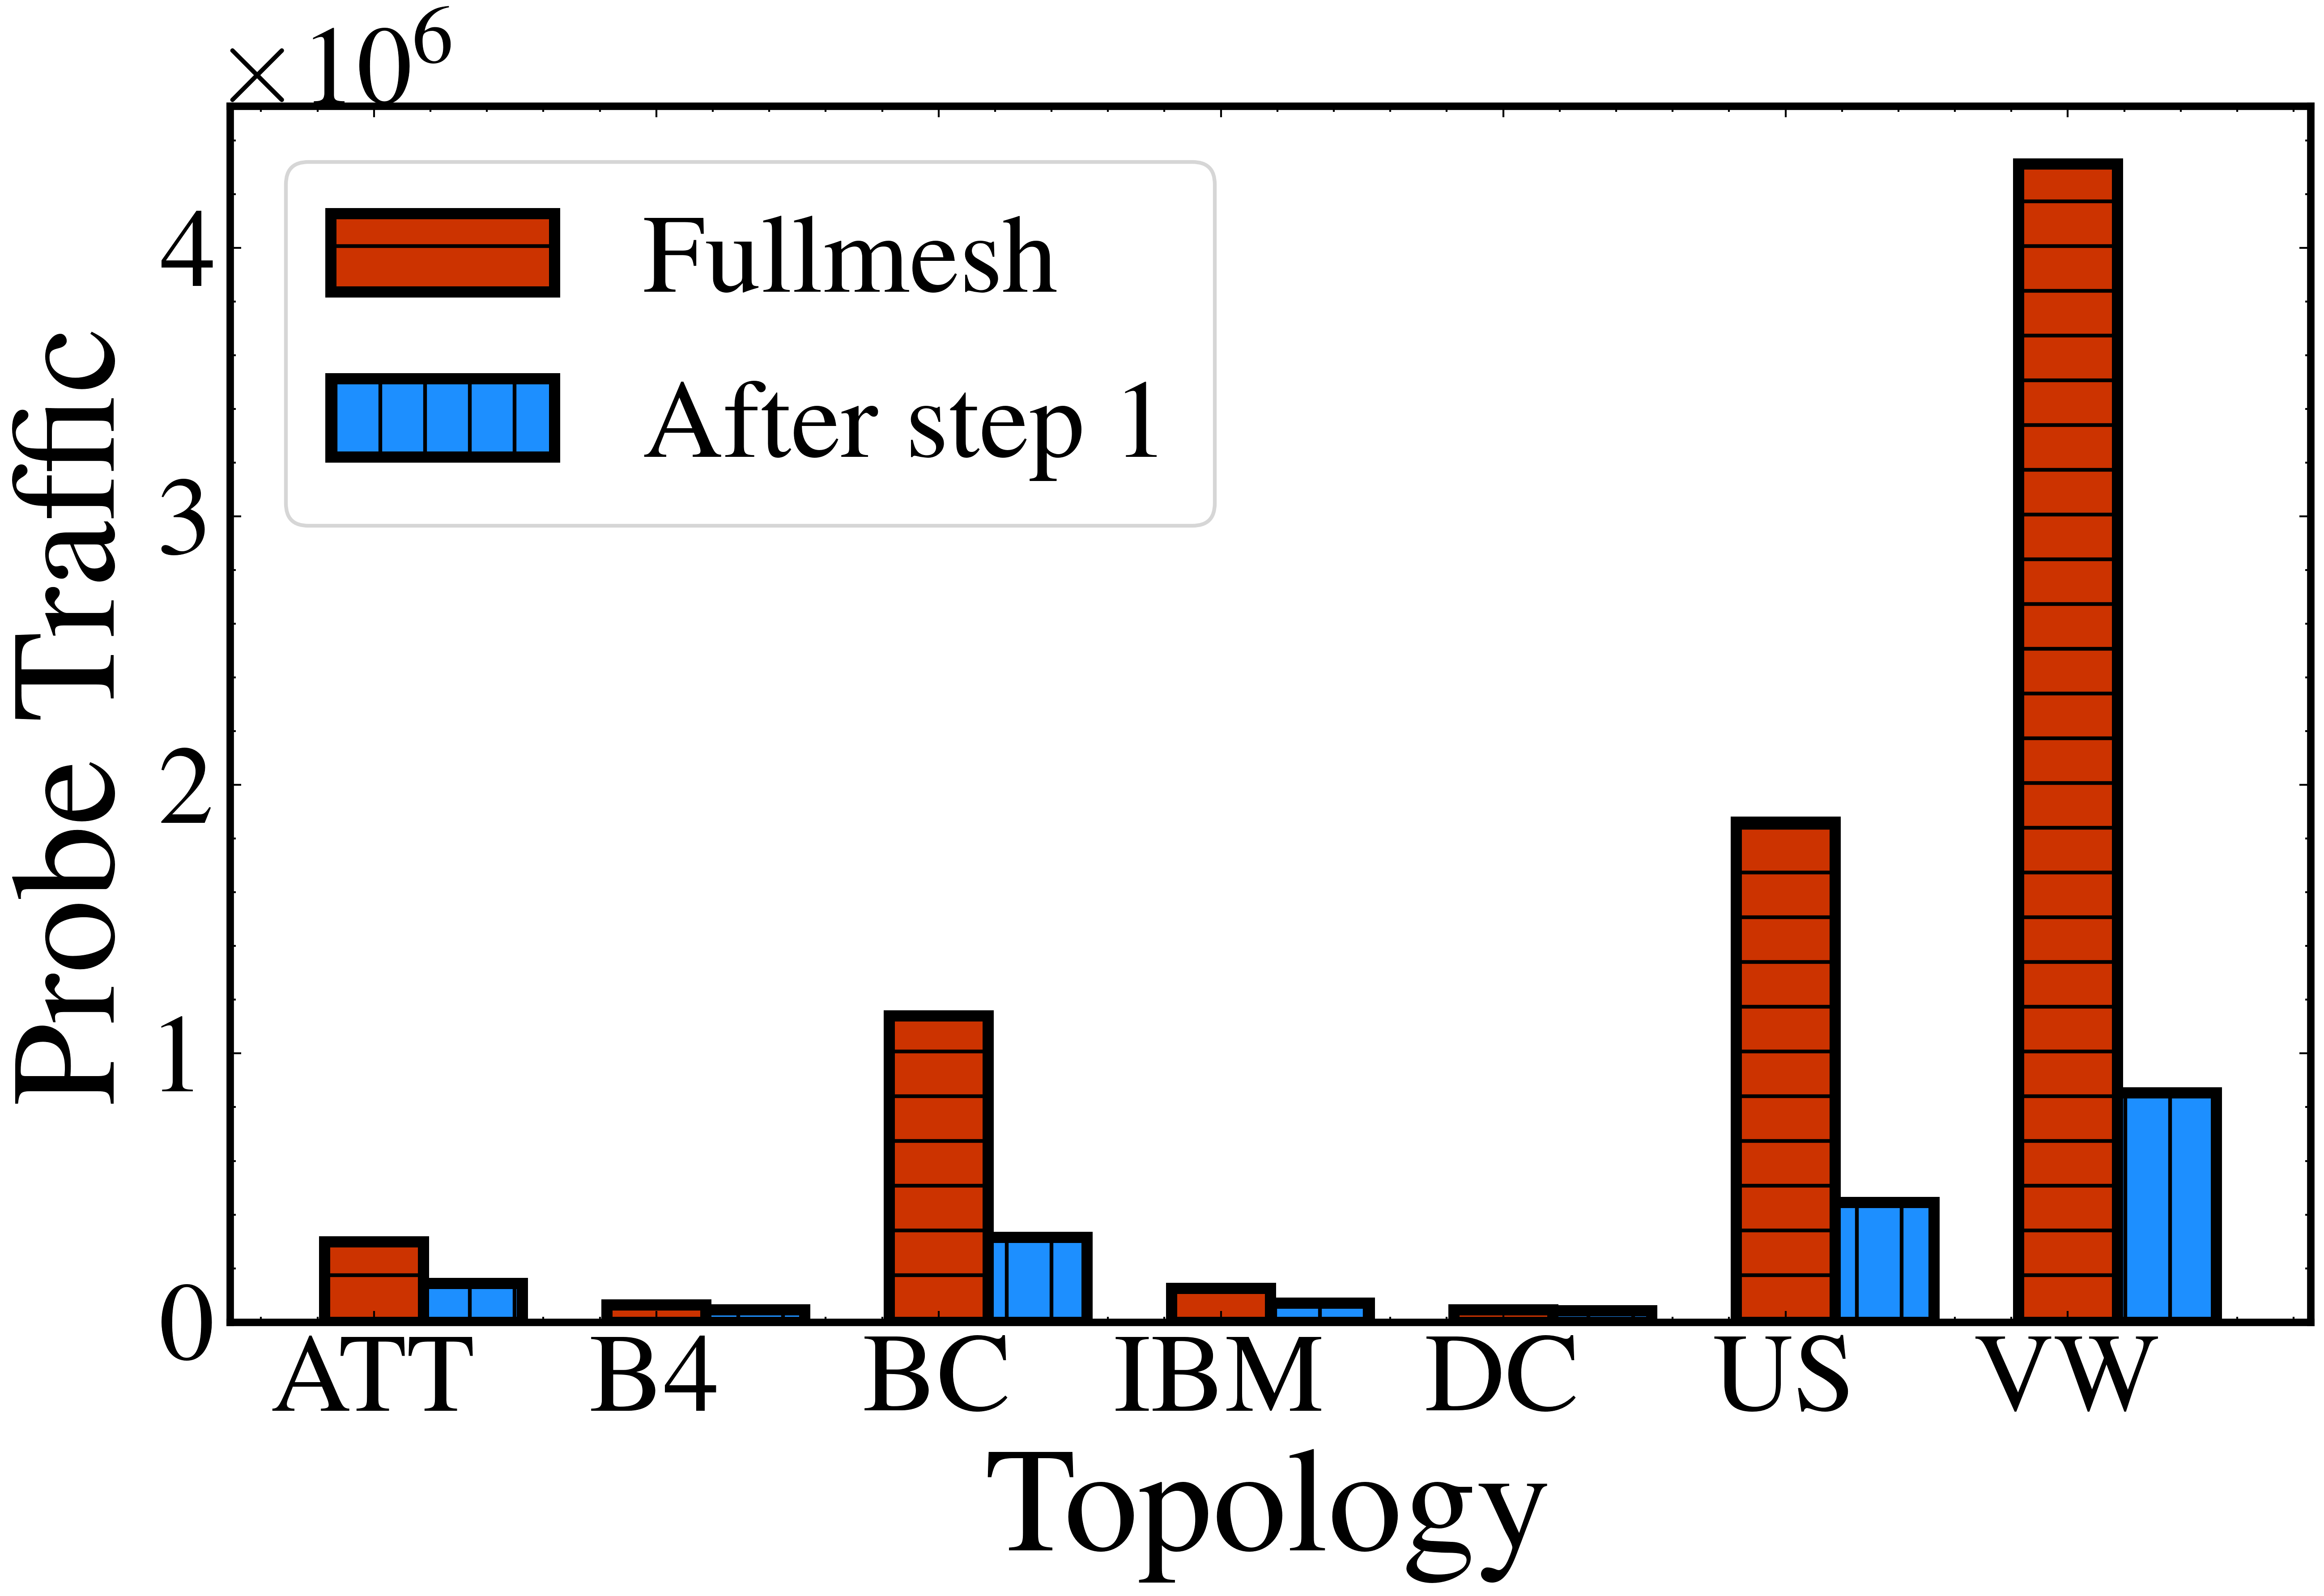

In [19]:
net = ['ATT','B4','BC','IBM', 'DC','US', 'VW']
res = []
for j in range(7):
    res.append([data[j][0],data[j][1]])
#柱状图，两个柱子
fig, ax = plt.subplots(figsize=(10, 6))
#ax.set_facecolor((249/255,247/255,243/255))
x = np.arange(7)
bar_width = 0.35
bars1=plt.bar(x, [i[0] for i in res], bar_width, color=colors[0], hatch='-',label='Fullmesh',linewidth=3, edgecolor='black')
bars2=plt.bar(x+bar_width, [i[1] for i in res], bar_width, color=colors[1], hatch = '|',label='After step 1',linewidth=3, edgecolor='black')
plt.xticks(x, net, fontsize=30)
plt.yticks(fontsize=30)
plt.gca().yaxis.get_offset_text().set_fontsize(30)
ax = plt.gca() # 获取当前坐标轴
ax.spines['bottom'].set_linewidth(2) # 设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2) # 设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2) # 设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(2) # 设置顶部坐标轴的粗细
plt.xlabel('Topology', fontsize=40)
plt.ylabel('Probe Traffic', fontsize=40)
plt.legend(loc='upper left', fontsize=30)
plt.savefig('plot//d3e1.png', dpi=600, bbox_inches='tight')
plt.show()

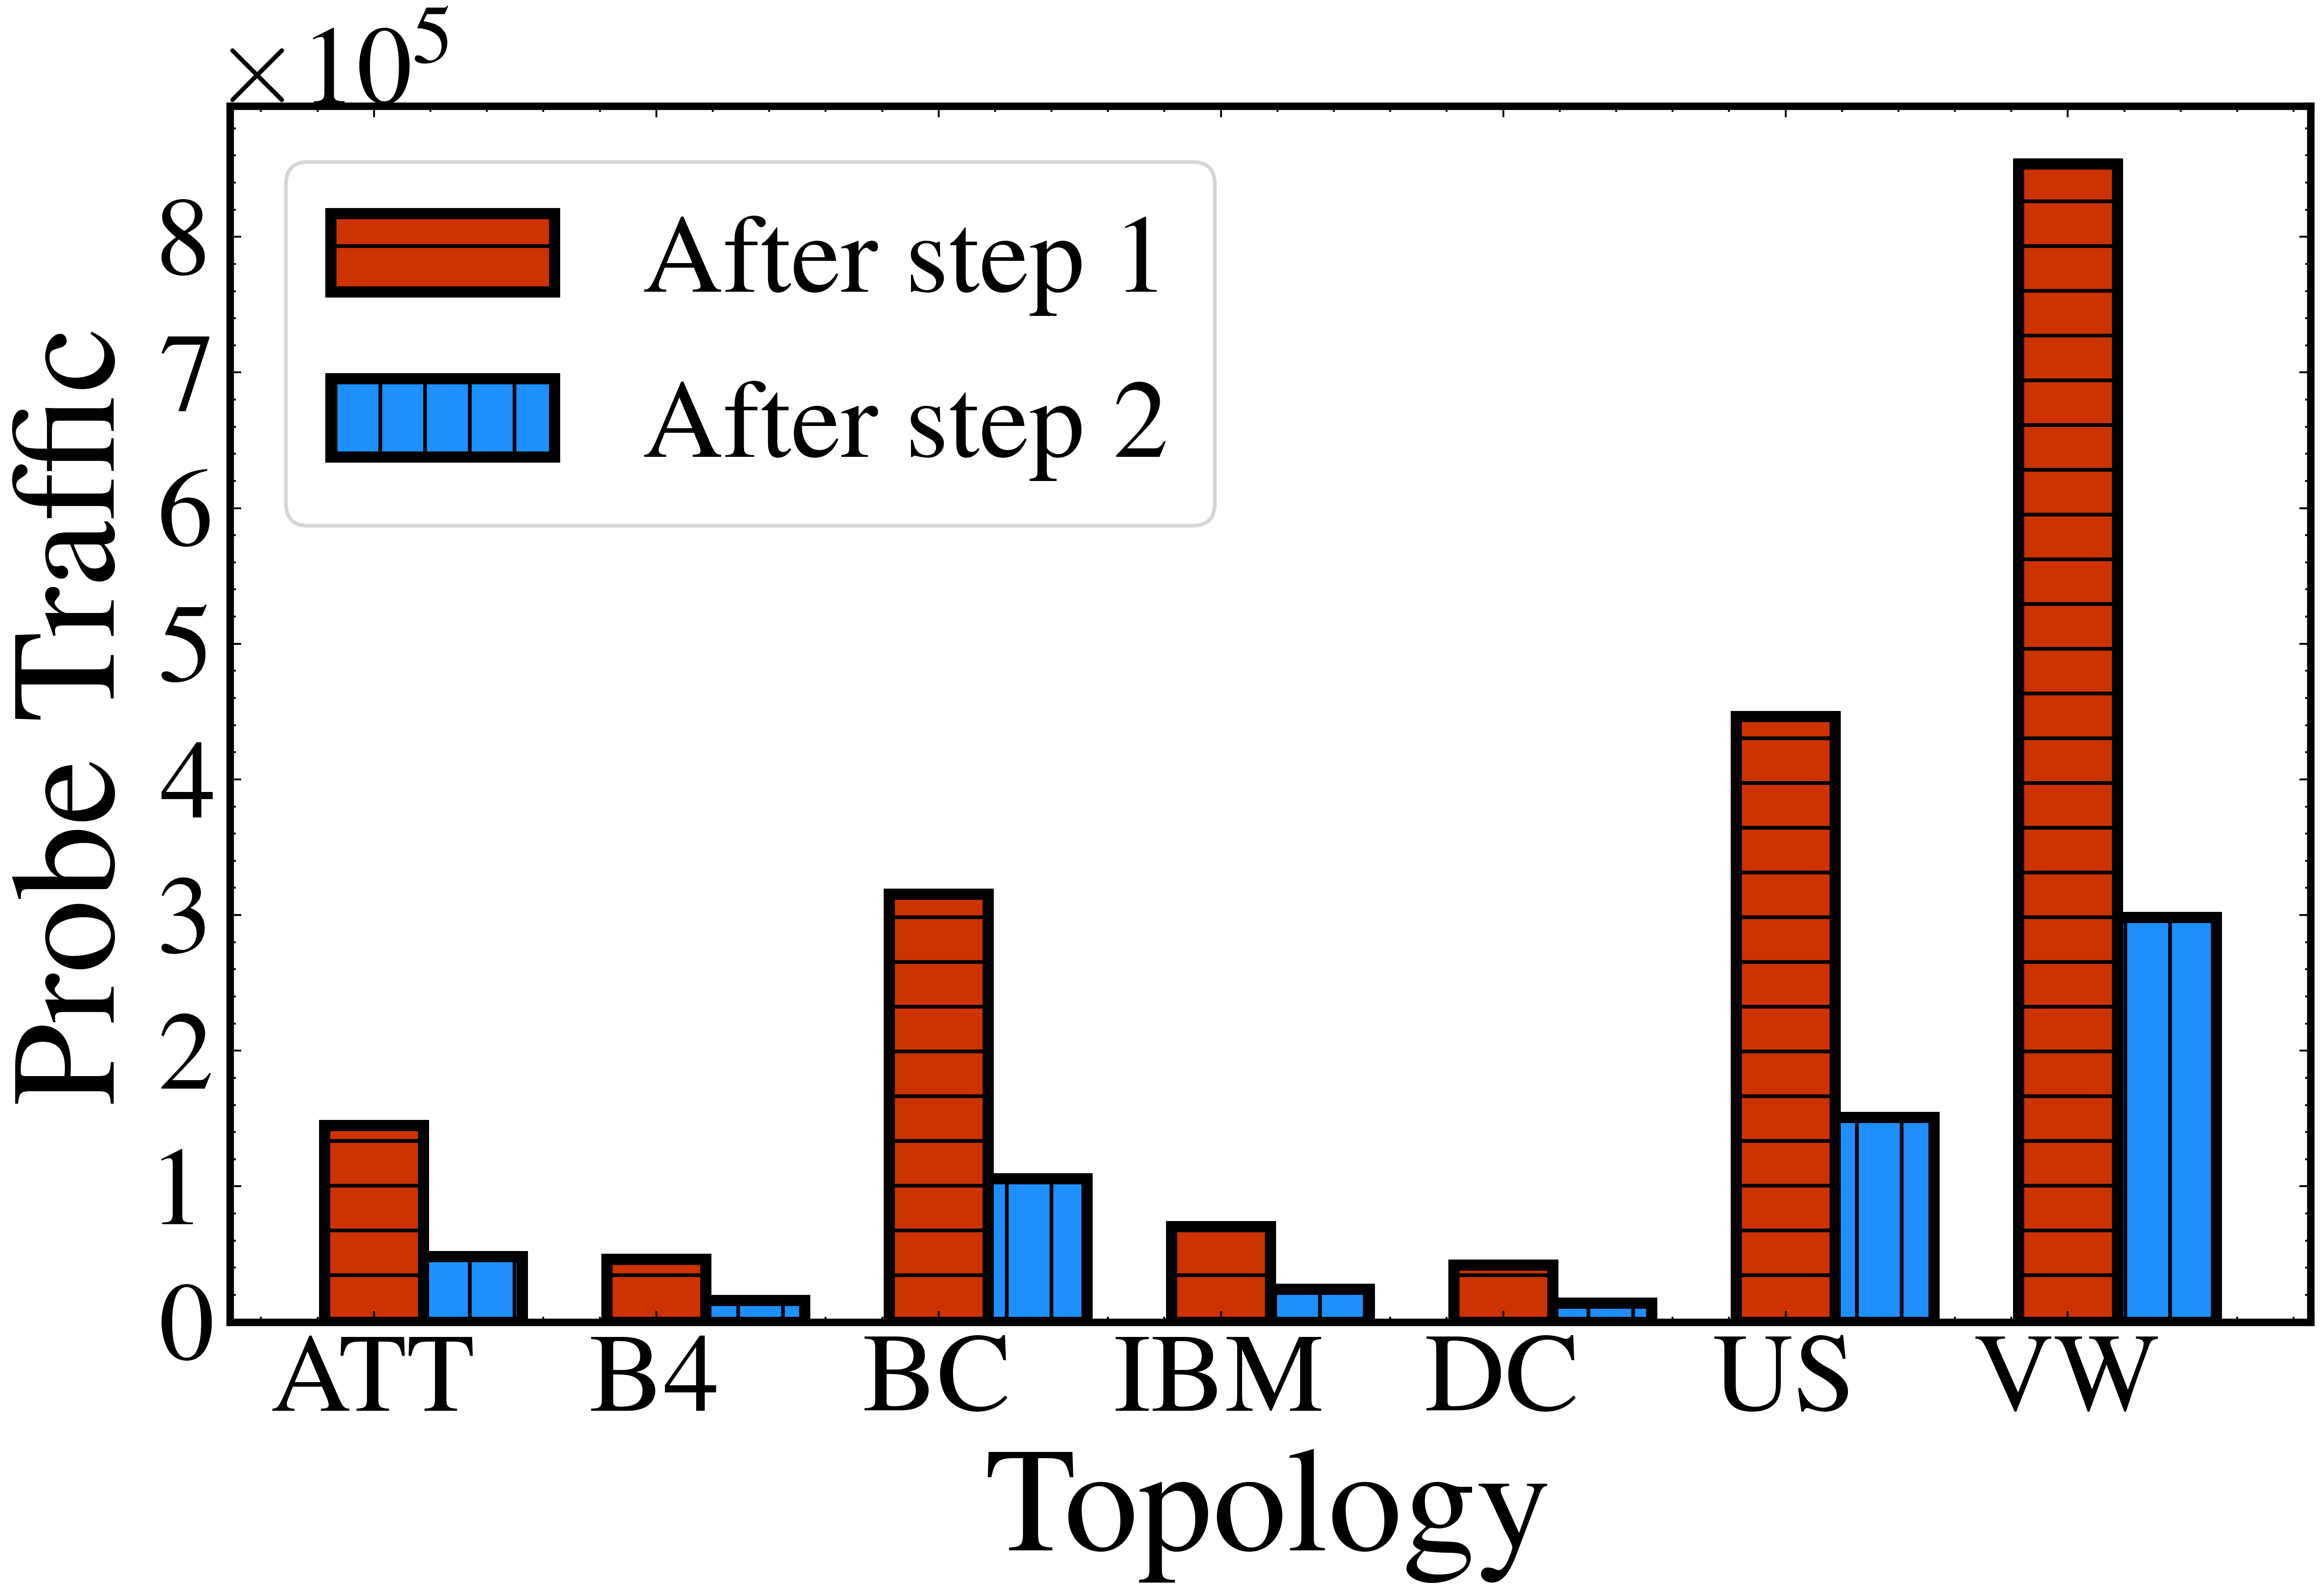

In [20]:
net = ['ATT','B4','BC','IBM', 'DC','US', 'VW']
res = []
for j in range(7):
    res.append([data[j][1],data[j][2]])

#柱状图，两个柱子
fig, ax = plt.subplots(figsize=(10, 6))
#ax.set_facecolor((249/255,247/255,243/255))
x = np.arange(7)
bar_width = 0.35
bars1=plt.bar(x, [i[0] for i in res], bar_width, color=colors[0],hatch='-',label='After step 1',linewidth=3, edgecolor='black')
bars2=plt.bar(x+bar_width, [i[1] for i in res], bar_width, color=colors[1],hatch='|',label='After step 2',linewidth=3, edgecolor='black')
plt.xticks(x, net, fontsize=30)
#科学计数法
plt.yticks(fontsize=30)
plt.gca().yaxis.get_offset_text().set_fontsize(30)
ax = plt.gca() # 获取当前坐标轴
ax.spines['bottom'].set_linewidth(2) # 设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2) # 设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2) # 设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(2) # 设置顶部坐标轴的粗细
plt.ticklabel_format(style='sci',scilimits=(0,0),axis='y')
plt.xlabel('Topology', fontsize=40)
plt.ylabel('Probe Traffic', fontsize=40)
plt.legend(loc='upper left', fontsize=30)
plt.savefig('plot//d3e2.png', dpi=600, bbox_inches='tight')
plt.show()

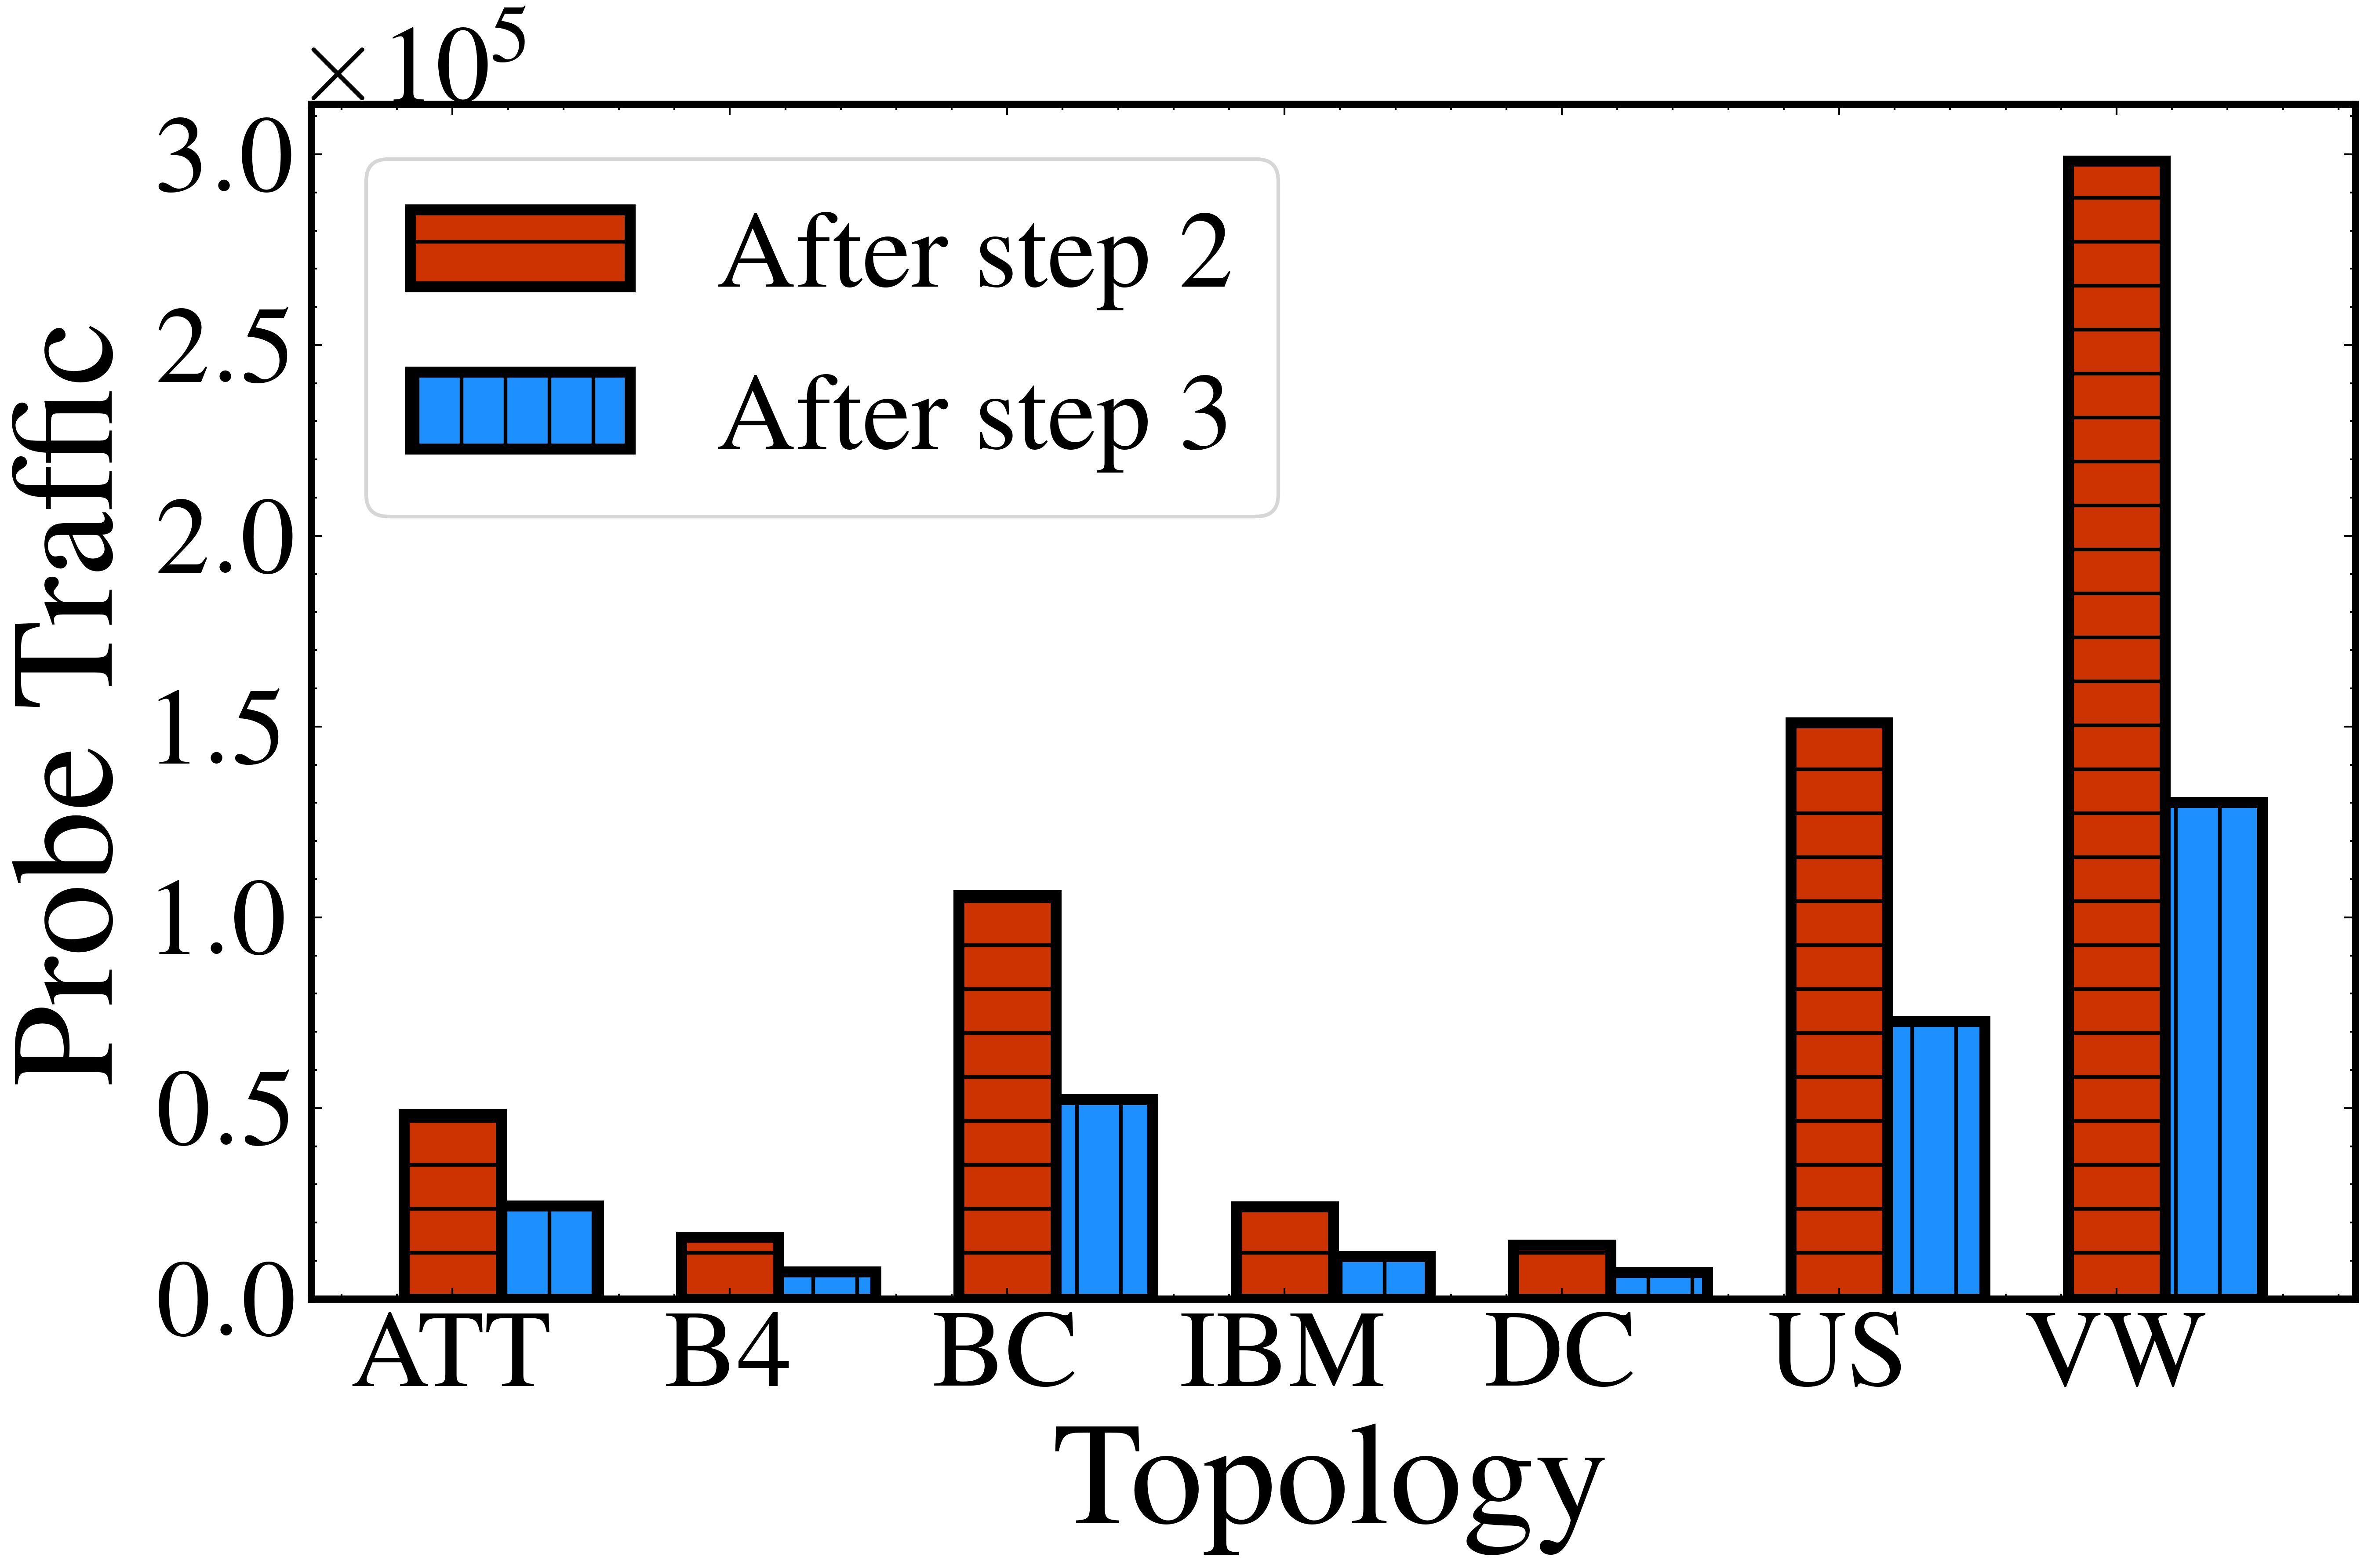

In [21]:
net = ['ATT','B4','BC','IBM', 'DC','US', 'VW']
res = []
for j in range(7):
    res.append([data[j][2],data[j][3]])
#柱状图，两个柱子
fig, ax = plt.subplots(figsize=(10, 6))
#ax.set_facecolor((249/255,247/255,243/255))
x = np.arange(7)
bar_width = 0.35
bars1=plt.bar(x, [i[0] for i in res], bar_width, color=colors[0],hatch='-',label='After step 2',linewidth=3, edgecolor='black')
bars2=plt.bar(x+bar_width, [i[1] for i in res], bar_width, color=colors[1],hatch='|',label='After step 3',linewidth=3, edgecolor='black')
plt.xticks(x, net, fontsize=30)
plt.yticks(fontsize=30)
plt.gca().yaxis.get_offset_text().set_fontsize(30)
ax = plt.gca() # 获取当前坐标轴
ax.spines['bottom'].set_linewidth(2) # 设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2) # 设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2) # 设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(2) # 设置顶部坐标轴的粗细
plt.ticklabel_format(style='sci',scilimits=(0,0),axis='y')
plt.xlabel('Topology', fontsize=40)
plt.ylabel('Probe Traffic', fontsize=40)
plt.legend(loc='upper left', fontsize=30)
plt.savefig('plot//d3e3.png', dpi=600, bbox_inches='tight')
plt.show()